In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio

# custom module
from data_processing import preprocess, visualize

In [3]:
# set constants
TRAINING_IMAGES_DIR = 'data/images/TRAIN' # directory/path to training images
TEST_IMAGES_DIR = 'data/images/TEST' # directory/path to test images
TRAINING_LABELS_PATH = 'data/labels.csv' # path to training labels csv
IMAGE_HEIGHT = 240 #pixels
IMAGE_WIDTH = 320 #pixels

# dictionaries mapping each label to an integer representation (or vice versa)
REP_TO_LABELS = {0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}
LABELS_TO_REP = {'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

In [4]:
# construct tf.data.Datasets to hold our data:t
train_set, val_set = preprocess.load_images_dataset(TRAINING_IMAGES_DIR,
                                                    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                    batch_size=10,
                                                    validation_split=0.2)

Found 9957 files belonging to 4 classes.
Using 7966 files for training.
Using 1991 files for validation.


In [6]:
# shuffle training set
train_set.shuffle(buffer_size=len(train_set))

<ShuffleDataset element_spec=(TensorSpec(shape=(None, 240, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

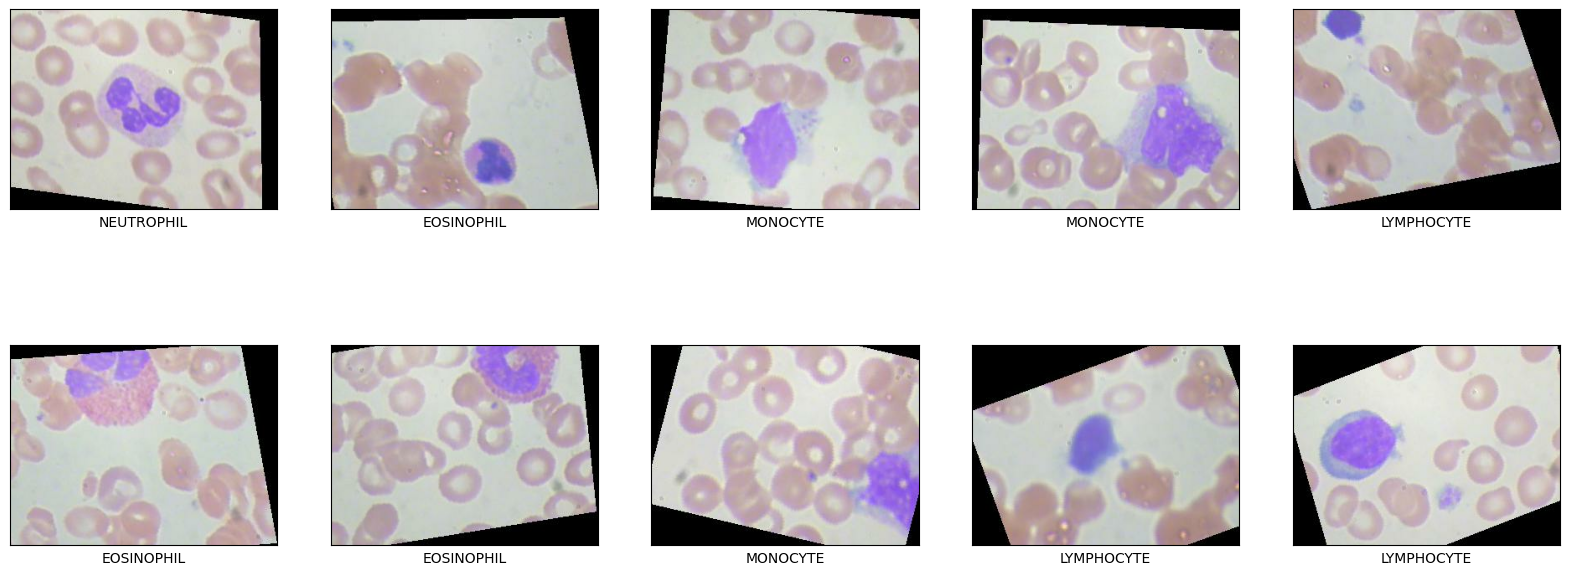

In [7]:
# visualize dataset
visualize.visualize_dataset(train_set, REP_TO_LABELS)

# Model 1: Custom-built Convolutional Neural Network

In [8]:
# import necessary packages
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Add, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# input layer
inputs = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

# Standard structure of convolutional layers followed by max pooling layers, repeated two times
x = Conv2D(32, (3,3), activation='relu')(inputs)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation = 'relu')(x)
x = MaxPooling2D((2,2))(x)

# Batch Normalization followed by dropout
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# depthwise convolution (for MobileNet)
x = DepthwiseConv2D((3, 3), activation='relu')(x)

# 1 by 1 convolution layer (for MobileNet)
# followed by max pooling, batch normalization, and dropout
x = Conv2D(64, (1, 1), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# Repeated once more
x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.03))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

# residual connection for ResNet
residual = Conv2D(64, (1, 1), padding='same')(x)  # added this line
x = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.03))(x)
# the main crux of applying ResNet
x = Add()([x, residual])
# Applying the ReLU activation function to the added layer
x = tf.keras.activations.relu(x)

# Again applying normalization techniques
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# flatten and dense layers
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.03))(x)

# Again applying normalization techniques
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# Final output layer
outputs = Dense(len(REP_TO_LABELS), activation='softmax')(x)

# create the model
model_built = Model(inputs=inputs, outputs=outputs)

In [9]:
model_built.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 238, 318, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 119, 159, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# compile the model
model_built.compile(optimizer='adam',
                    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

# define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# train the model and save its history
history_built = model_built.fit(train_set,
                                epochs=400,
                                validation_data=val_set,
                                callbacks=[early_stopping])

Epoch 1/400
70/70 [==============================] - 132s 2s/step - loss: 7.4636 - accuracy: 0.3531 - val_loss: 6.3018 - val_accuracy: 0.2482
Epoch 2/400
70/70 [==============================] - 158s 2s/step - loss: 5.2397 - accuracy: 0.4853 - val_loss: 4.8456 - val_accuracy: 0.2446
Epoch 3/400
70/70 [==============================] - 182s 3s/step - loss: 3.6625 - accuracy: 0.6138 - val_loss: 4.0422 - val_accuracy: 0.2446
Epoch 4/400
70/70 [==============================] - 145s 2s/step - loss: 2.6226 - accuracy: 0.7013 - val_loss: 3.5059 - val_accuracy: 0.2446
Epoch 5/400
70/70 [==============================] - 16418s 238s/step - loss: 1.9578 - accuracy: 0.7353 - val_loss: 4.3725 - val_accuracy: 0.2446
Epoch 6/400
70/70 [==============================] - 132s 2s/step - loss: 1.5381 - accuracy: 0.7621 - val_loss: 3.3458 - val_accuracy: 0.2946
Epoch 7/400
70/70 [==============================] - 104s 1s/step - loss: 1.1681 - accuracy: 0.8147 - val_loss: 5.8639 - val_accuracy: 0.2339
Ep

In the above model ```model_built```, we have implimented ResNet, Batch Normalization, Dropout, and MobileNet, the last of which uses $1 \times 1$ convolution and Depthwise convolution. We first chose to have convolutional layers followed by max pooling layers, repeated two times, with the number of filters increasing from $32$ to $64$ as it's part of a standard convolutional neural network technique. We first thought of having 3 repeats, with the number of filters increasing from $32$ to $64$ and then to $128$, but doing so made our computer crash, so we had to simplify our model. We chose the number of filters to increase from $32$ to $64$ since we wanted the model to capture more complex features as the depth increased.

Batch Normalization is normalizing the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. It helps to standardize the inputs to each layer and this helps to combat the internal covariate shift problem, leading to faster training and reduces the sensitivity to the initial starting weights.

Dropout is a regularization technique used in neural networks to prevent overfitting. During training, dropout randomly “drops out” (i.e., sets to zero) a fraction of the output features of the layer at each update. This fraction is determined by the dropout rate specified as parameter. In effect, having a dropout layer creates a version of the neural network that is missing some neurons, and this version is used for training. Since the neuraons that are dropped out change during traning, our final training model will be less reliant on any single neuron, thus making our network less likely to overfit.

We chose then to impliment the MobileNet, since we wanted to impliment this structure that we have not encountered in class, and since one of the advantages of using MobileNet is that it uses fewer computational resources.

We now describe how MobileNet works in detail. It consists of two key components, $1 \times 1$ convolutions and depthwise convolutions. A $1 \times 1$ convolution is a regular convolutional layer with a filter size of $1 \times 1$. It's used to reduce the dimensionality in the filter space, allowing us to perform dimensionality reduction. A deptwise convolution is a convolutional layer that applies a single filter to each input channel, unlike a regular convolutional layer that applies a filter that spans across all input channels. Depthwise convolutions are computationally efficient as they can reduce the number of parameters and computations in our neural network. MobileNet is a structure in which we first apply depthwise convolution and then apply $1 \times 1$ convolution.

We also chose the dropout rates of $0.25$ because we found that using $0.2$ led to overfitting, and we saught to mitigate overfitting by increasing the dropout rates as we thought that it could result in our model learning more generalized features of our data.

We chose to impliment ResNet at later stages of our model because our model had many structures and we thought that ResNet could have great impact on mitigating the exploding/vanishing gradient problem if it was implimented at later layers of our model rather than earlier layers.

As for our fully connected layer after the convolutional layers, we were initially thinking about having one fully connected layer with 512 units, but that seemed to take our computer a lot of time to train. We then experimented with two fully connected layers with $128$ and $256$ units respectively, but that choice still made our model take a lot of time to train and our model still was overfitting. We thus chose for a simpler structure of having only one fully connected layer with 256 units.
Since our model was still overfitting, we chose then to apply the L2 regulariation technique to further mitigate the impact of overfitting. According to ChatGPT, I learned that "in general, applying regularization to the later layers can often be more effective at reducing overfitting. This is because the later layers in the network are where the more abstract and complex features are learned. These are the features that are more likely to fit to the noise in the training data, leading to overfitting." Although ChatGPT warned us that this is "not a hard and fast rule," we took its explanation into consideration and chose to apply several L2 regularization at later stages of our model architecture.

Because our model was running way too slowly, we decided to impliment a simpler version of our model, simplifying or removing certain layers and using smaller number of units for many layers.

In [ ]:
# input layer
inputs1 = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

# Standard structure of convolutional layers followed by max pooling layers, repeated two times
x1 = Conv2D(32, (3,3), activation='relu')(inputs1)
x1 = MaxPooling2D((2,2))(x1)

# Batch Normalization followed by dropout
x1 = BatchNormalization()(x1)
x1 = Dropout(0.25)(x1)

# depthwise convolution (for MobileNet)
x1 = DepthwiseConv2D((3, 3), activation='relu')(x1)

# 1 by 1 convolution layer (for MobileNet)
# followed by max pooling, batch normalization, and dropout
x1 = Conv2D(32, (1, 1), activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.25)(x1)

# residual connection for ResNet
residual = Conv2D(32, (1, 1), padding='same')(x1)
x1 = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.03))(x1)
# the main crux of applying ResNet
x1 = Add()([x1, residual])
# Applying the ReLU activation function to the added layer
x1 = tf.keras.activations.relu(x1)

# flatten and dense layers
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.03))(x1)

# Again applying normalization techniques
x1 = BatchNormalization()(x1)
x1 = Dropout(0.25)(x1)

# Final output layer
outputs1 = Dense(len(REP_TO_LABELS), activation='softmax')(x1)

# create the model
model_built1 = Model(inputs=inputs1, outputs=outputs1)

model_built1.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# compile the model
model_built1.compile(optimizer='adam',
                     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

# define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# train the model and save its history
history_built1 = model_built1.fit(train_set,
                                  epochs=400,
                                  validation_data=val_set,
                                  callbacks=[early_stopping])

Now, we shall graph the training and validation accuracy of our model ```model_built```:

In [10]:
# plot for model_built
visualize.visualize_history(history_built)

NameError: name 'history_built' is not defined

In [ ]:
# plot for model_built1
visualize.visualize_history(history_built1)

Now, we can see how our model ```model_built``` performs on the simple test dataset.

In [ ]:
# load test set
test_set = preprocess.load_images_dataset(TEST_IMAGES_DIR,
                                          target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                          batch_size=1)

# evaluate the model on the test set
test_loss, test_accuracy = model_enet_tl.evaluate(test_set)

print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

We'll now pick ten random datapoints from our simple test dataset and display the true and predicted labels.

In [ ]:
visualize.visualize_predictions(model_enet_tl, test_set, REP_TO_LABELS)